In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from preprocessor import get_train_environment

# Tune n_estimators & max_depth

In [32]:
# Define parameter grid
n_estimators = [100, 500,1000,5000]
max_depth = list(range(1, 6, 1))
param_grid = [(n, d) for n in n_estimators for d in max_depth]

# Initialize variables to track the best parameters
best_params = (1,100)
best_score = float('inf')

# Iterate over all combinations of parameters
for n, d in param_grid:
    mse_scores = []
    print(n,d)
    
    # Iterate over folds
    envGen = get_train_environment(n_splits=5)
    # The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
    stats, X, X_holdout, y, y_holdout = next(envGen)
    
    for fold, stats, X_train, X_test, y_train, y_test in envGen:
        print(fold)
        if len(X_train) == 0 or len(X_test) == 0:
            print(f"Skipping empty fold: {fold}")
            continue

        # Create and fit the model
        model = XGBRegressor(n_estimators=n, max_depth=d)
        model.fit(X_train, y_train)

        # Predict and evaluate
        predictions = model.predict(X_test)

        # Check if predictions are valid
        if not np.any(np.isnan(predictions)):
            mse = mean_squared_error(y_test, predictions)
            print("Mean Squared Error: ", mse)
            r2 = r2_score(y_test, predictions)
            print("R-Squared: ", r2)
            mse_scores.append(mse)
        else:
            print(f"Invalid predictions in fold: {fold}")       

        # make predictions for test data and evaluate


    # Average MSE across folds for current parameter combination
    avg_mse = np.mean(mse_scores)
    #print("avg",avg_mse)

    # Update best parameters if current combination is better
    if avg_mse < best_score:
        best_score = avg_mse
        best_params = (n, d)


100 1
Found cached folds, using those
0
Mean Squared Error:  0.49131311869396954
R-Squared:  0.6557437414570069
1
Mean Squared Error:  0.46231731399619364
R-Squared:  0.6562384142780381
2
Mean Squared Error:  0.4615412807191138
R-Squared:  0.6500021977135685
3
Mean Squared Error:  0.46675612743592404
R-Squared:  0.6617313711882743
4
Mean Squared Error:  0.4673663278060409
R-Squared:  0.6561410415278244
100 2
Found cached folds, using those
0
Mean Squared Error:  0.40805241872453957
R-Squared:  0.7140833541490921
1
Mean Squared Error:  0.3874949417866693
R-Squared:  0.7118734868559963
2
Mean Squared Error:  0.37635941114482097
R-Squared:  0.7145976486322825
3
Mean Squared Error:  0.3850325275501561
R-Squared:  0.7209582960211183
4
Mean Squared Error:  0.39676109812919713
R-Squared:  0.7080879604540073
100 3
Found cached folds, using those
0
Mean Squared Error:  0.37978454867014844
R-Squared:  0.7338902569400712
1
Mean Squared Error:  0.3692235374317824
R-Squared:  0.7254594087850521
2
M

In [33]:
print(f"Best parameters: n_estimators={best_params[0]}, max_depth={best_params[1]} with MSE: {best_score}")

Best parameters: n_estimators=500, max_depth=4 with MSE: 0.3434679680297569


In [4]:

results = []
# The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
stats, X, X_holdout, y, y_holdout = next(envGen)

# Cross validation folds
for fold, stats, X_train_fold, X_test_fold, y_train_fold, y_test_fold in envGen:
    print(f"Fold: {fold}")
    model = XGBRegressor()
    model.fit(X_train_fold, y_train_fold)

    print(model.feature_importances_)
    # make predictions for test data and evaluate
    predictions = model.predict(X_test_fold)

    mse = mean_squared_error(y_test_fold, predictions)
    print("Mean Squared Error: ", mse)
    r2 = r2_score(y_test_fold, predictions)
    print("R-Squared: ", r2)

    thresholds = np.sort(model.feature_importances_)[::-1]
    # Fit model using each importance as a threshold
    for thresh in thresholds:
        if thresh > 0.001:
            # Select features using threshold
            selection = SelectFromModel(model, threshold=thresh, prefit=True)
            select_X_train_fold = selection.transform(X_train_fold)

            # Get names of selected features
            #selected_features = X_train_fold.columns[selection.get_support()]

            # Train model
            selection_model = XGBRegressor()
            selection_model.fit(select_X_train_fold, y_train_fold)

            # Eval model
            select_X_test = selection.transform(X_test_fold)
            predictions = selection_model.predict(select_X_test)
            mse_select = mean_squared_error(y_test_fold, predictions)
            r2_select = r2_score(y_test_fold, predictions)
            adjusted_r2_select = 1 - (((1 - r2_select) * (len(y_train_fold) - 1)) / (len(y_train_fold) - select_X_train_fold.shape[1] - 1))

            # Save results to dictionary
            results_dict = {
                'Fold':fold,
                'Threshold': thresh,
                #'Selected Features': list(selected_features),
                'Number of Features': select_X_train_fold.shape[1],
                'MSE': mse_select,
                'R2': r2_select,
                'Adjusted R2': adjusted_r2_select
            }
            results.append(results_dict)
            #print("Thresh=%.7f, n=%d, Mean Squared Error: %.4f, R-Squared: %.4f, Adj-R-Squared: %.4f" % (thresh, select_X_train_fold.shape[1], mse_select, r2_select, adjusted_r2_select))
        else:
            break

Found cached folds, using those
Fold: 0
[0.00104952 0.0034177  0.00023236 ... 0.0045207  0.00131164 0.00490129]
Mean Squared Error:  0.3538887002525175
R-Squared:  0.736100240604373
Thresh=0.1637363, n=1, Mean Squared Error: 0.9553, R-Squared: 0.2877, Adj-R-Squared: 0.2876
Thresh=0.1361719, n=2, Mean Squared Error: 0.7134, R-Squared: 0.4680, Adj-R-Squared: 0.4679
Thresh=0.0168594, n=3, Mean Squared Error: 0.6693, R-Squared: 0.5009, Adj-R-Squared: 0.5007
Thresh=0.0133396, n=4, Mean Squared Error: 0.6436, R-Squared: 0.5200, Adj-R-Squared: 0.5198
Thresh=0.0124171, n=5, Mean Squared Error: 0.6232, R-Squared: 0.5353, Adj-R-Squared: 0.5350
Thresh=0.0119607, n=6, Mean Squared Error: 0.6150, R-Squared: 0.5414, Adj-R-Squared: 0.5410
Thresh=0.0112620, n=7, Mean Squared Error: 0.6215, R-Squared: 0.5365, Adj-R-Squared: 0.5361
Thresh=0.0100828, n=8, Mean Squared Error: 0.6158, R-Squared: 0.5408, Adj-R-Squared: 0.5403
Thresh=0.0097318, n=9, Mean Squared Error: 0.6098, R-Squared: 0.5452, Adj-R-Square

Thresh=0.0019730, n=88, Mean Squared Error: 0.4149, R-Squared: 0.6906, Adj-R-Squared: 0.6873
Thresh=0.0019709, n=89, Mean Squared Error: 0.4149, R-Squared: 0.6906, Adj-R-Squared: 0.6873
Thresh=0.0019672, n=90, Mean Squared Error: 0.4137, R-Squared: 0.6915, Adj-R-Squared: 0.6882
Thresh=0.0019608, n=91, Mean Squared Error: 0.4161, R-Squared: 0.6897, Adj-R-Squared: 0.6863
Thresh=0.0019209, n=92, Mean Squared Error: 0.4097, R-Squared: 0.6945, Adj-R-Squared: 0.6911
Thresh=0.0019028, n=93, Mean Squared Error: 0.4216, R-Squared: 0.6856, Adj-R-Squared: 0.6821
Thresh=0.0018894, n=94, Mean Squared Error: 0.4191, R-Squared: 0.6875, Adj-R-Squared: 0.6840
Thresh=0.0018727, n=95, Mean Squared Error: 0.4287, R-Squared: 0.6803, Adj-R-Squared: 0.6767
Thresh=0.0018619, n=96, Mean Squared Error: 0.4101, R-Squared: 0.6942, Adj-R-Squared: 0.6907
Thresh=0.0018574, n=97, Mean Squared Error: 0.4221, R-Squared: 0.6852, Adj-R-Squared: 0.6816
Thresh=0.0018536, n=98, Mean Squared Error: 0.4232, R-Squared: 0.6844,

Thresh=0.0012545, n=176, Mean Squared Error: 0.3783, R-Squared: 0.7179, Adj-R-Squared: 0.7120
Thresh=0.0012499, n=177, Mean Squared Error: 0.3706, R-Squared: 0.7236, Adj-R-Squared: 0.7178
Thresh=0.0012496, n=178, Mean Squared Error: 0.3647, R-Squared: 0.7280, Adj-R-Squared: 0.7222
Thresh=0.0012385, n=179, Mean Squared Error: 0.3769, R-Squared: 0.7189, Adj-R-Squared: 0.7129
Thresh=0.0012203, n=180, Mean Squared Error: 0.3703, R-Squared: 0.7239, Adj-R-Squared: 0.7179
Thresh=0.0012192, n=181, Mean Squared Error: 0.3694, R-Squared: 0.7245, Adj-R-Squared: 0.7185
Thresh=0.0012139, n=182, Mean Squared Error: 0.3707, R-Squared: 0.7236, Adj-R-Squared: 0.7175
Thresh=0.0012120, n=183, Mean Squared Error: 0.3723, R-Squared: 0.7223, Adj-R-Squared: 0.7162
Thresh=0.0012080, n=184, Mean Squared Error: 0.3687, R-Squared: 0.7250, Adj-R-Squared: 0.7190
Thresh=0.0011868, n=185, Mean Squared Error: 0.3727, R-Squared: 0.7221, Adj-R-Squared: 0.7159
Thresh=0.0011868, n=186, Mean Squared Error: 0.3582, R-Squar

Thresh=0.0034475, n=43, Mean Squared Error: 0.4088, R-Squared: 0.7117, Adj-R-Squared: 0.7102
Thresh=0.0034338, n=44, Mean Squared Error: 0.4061, R-Squared: 0.7135, Adj-R-Squared: 0.7120
Thresh=0.0034313, n=45, Mean Squared Error: 0.4038, R-Squared: 0.7152, Adj-R-Squared: 0.7137
Thresh=0.0034189, n=46, Mean Squared Error: 0.4158, R-Squared: 0.7067, Adj-R-Squared: 0.7051
Thresh=0.0033724, n=47, Mean Squared Error: 0.4054, R-Squared: 0.7140, Adj-R-Squared: 0.7124
Thresh=0.0033590, n=48, Mean Squared Error: 0.4007, R-Squared: 0.7174, Adj-R-Squared: 0.7158
Thresh=0.0033496, n=49, Mean Squared Error: 0.4060, R-Squared: 0.7136, Adj-R-Squared: 0.7119
Thresh=0.0032588, n=50, Mean Squared Error: 0.4197, R-Squared: 0.7039, Adj-R-Squared: 0.7022
Thresh=0.0032521, n=51, Mean Squared Error: 0.4113, R-Squared: 0.7099, Adj-R-Squared: 0.7082
Thresh=0.0032069, n=52, Mean Squared Error: 0.4056, R-Squared: 0.7139, Adj-R-Squared: 0.7122
Thresh=0.0031156, n=53, Mean Squared Error: 0.4096, R-Squared: 0.7111,

Thresh=0.0015867, n=131, Mean Squared Error: 0.3413, R-Squared: 0.7592, Adj-R-Squared: 0.7555
Thresh=0.0015850, n=132, Mean Squared Error: 0.3462, R-Squared: 0.7558, Adj-R-Squared: 0.7520
Thresh=0.0015850, n=133, Mean Squared Error: 0.3445, R-Squared: 0.7570, Adj-R-Squared: 0.7532
Thresh=0.0015846, n=134, Mean Squared Error: 0.3531, R-Squared: 0.7510, Adj-R-Squared: 0.7470
Thresh=0.0015795, n=135, Mean Squared Error: 0.3419, R-Squared: 0.7588, Adj-R-Squared: 0.7549
Thresh=0.0015792, n=136, Mean Squared Error: 0.3379, R-Squared: 0.7617, Adj-R-Squared: 0.7578
Thresh=0.0015589, n=137, Mean Squared Error: 0.3481, R-Squared: 0.7544, Adj-R-Squared: 0.7504
Thresh=0.0015582, n=138, Mean Squared Error: 0.3433, R-Squared: 0.7578, Adj-R-Squared: 0.7538
Thresh=0.0015527, n=139, Mean Squared Error: 0.3373, R-Squared: 0.7621, Adj-R-Squared: 0.7581
Thresh=0.0015484, n=140, Mean Squared Error: 0.3567, R-Squared: 0.7484, Adj-R-Squared: 0.7442
Thresh=0.0015430, n=141, Mean Squared Error: 0.3556, R-Squar

Thresh=0.0141108, n=3, Mean Squared Error: 0.7088, R-Squared: 0.4843, Adj-R-Squared: 0.4841
Thresh=0.0140505, n=4, Mean Squared Error: 0.7190, R-Squared: 0.4769, Adj-R-Squared: 0.4767
Thresh=0.0128248, n=5, Mean Squared Error: 0.6900, R-Squared: 0.4980, Adj-R-Squared: 0.4977
Thresh=0.0122911, n=6, Mean Squared Error: 0.6502, R-Squared: 0.5270, Adj-R-Squared: 0.5267
Thresh=0.0116113, n=7, Mean Squared Error: 0.6444, R-Squared: 0.5312, Adj-R-Squared: 0.5308
Thresh=0.0110082, n=8, Mean Squared Error: 0.6301, R-Squared: 0.5416, Adj-R-Squared: 0.5411
Thresh=0.0106627, n=9, Mean Squared Error: 0.6276, R-Squared: 0.5434, Adj-R-Squared: 0.5429
Thresh=0.0090366, n=10, Mean Squared Error: 0.6109, R-Squared: 0.5555, Adj-R-Squared: 0.5550
Thresh=0.0088783, n=11, Mean Squared Error: 0.5499, R-Squared: 0.5999, Adj-R-Squared: 0.5994
Thresh=0.0083829, n=12, Mean Squared Error: 0.5416, R-Squared: 0.6060, Adj-R-Squared: 0.6054
Thresh=0.0083318, n=13, Mean Squared Error: 0.5415, R-Squared: 0.6061, Adj-R-

Thresh=0.0019980, n=92, Mean Squared Error: 0.4238, R-Squared: 0.6917, Adj-R-Squared: 0.6883
Thresh=0.0019526, n=93, Mean Squared Error: 0.4206, R-Squared: 0.6940, Adj-R-Squared: 0.6906
Thresh=0.0019238, n=94, Mean Squared Error: 0.4206, R-Squared: 0.6940, Adj-R-Squared: 0.6906
Thresh=0.0019227, n=95, Mean Squared Error: 0.4094, R-Squared: 0.7021, Adj-R-Squared: 0.6988
Thresh=0.0019003, n=96, Mean Squared Error: 0.4163, R-Squared: 0.6971, Adj-R-Squared: 0.6937
Thresh=0.0018842, n=97, Mean Squared Error: 0.4306, R-Squared: 0.6867, Adj-R-Squared: 0.6831
Thresh=0.0018662, n=98, Mean Squared Error: 0.4042, R-Squared: 0.7060, Adj-R-Squared: 0.7025
Thresh=0.0018586, n=99, Mean Squared Error: 0.4209, R-Squared: 0.6938, Adj-R-Squared: 0.6902
Thresh=0.0018470, n=100, Mean Squared Error: 0.4103, R-Squared: 0.7015, Adj-R-Squared: 0.6980
Thresh=0.0018403, n=101, Mean Squared Error: 0.4193, R-Squared: 0.6949, Adj-R-Squared: 0.6913
Thresh=0.0018389, n=102, Mean Squared Error: 0.4206, R-Squared: 0.69

Thresh=0.0012662, n=180, Mean Squared Error: 0.3725, R-Squared: 0.7290, Adj-R-Squared: 0.7232
Thresh=0.0012610, n=181, Mean Squared Error: 0.3777, R-Squared: 0.7252, Adj-R-Squared: 0.7192
Thresh=0.0012532, n=182, Mean Squared Error: 0.3790, R-Squared: 0.7242, Adj-R-Squared: 0.7182
Thresh=0.0012530, n=183, Mean Squared Error: 0.3717, R-Squared: 0.7296, Adj-R-Squared: 0.7237
Thresh=0.0012464, n=184, Mean Squared Error: 0.3655, R-Squared: 0.7341, Adj-R-Squared: 0.7282
Thresh=0.0012415, n=185, Mean Squared Error: 0.3746, R-Squared: 0.7275, Adj-R-Squared: 0.7214
Thresh=0.0012383, n=186, Mean Squared Error: 0.3774, R-Squared: 0.7254, Adj-R-Squared: 0.7193
Thresh=0.0012313, n=187, Mean Squared Error: 0.3744, R-Squared: 0.7276, Adj-R-Squared: 0.7215
Thresh=0.0012271, n=188, Mean Squared Error: 0.3762, R-Squared: 0.7263, Adj-R-Squared: 0.7201
Thresh=0.0012267, n=189, Mean Squared Error: 0.3679, R-Squared: 0.7323, Adj-R-Squared: 0.7262
Thresh=0.0012171, n=190, Mean Squared Error: 0.3731, R-Squar

Thresh=0.0036114, n=38, Mean Squared Error: 0.4126, R-Squared: 0.7109, Adj-R-Squared: 0.7096
Thresh=0.0034986, n=39, Mean Squared Error: 0.4010, R-Squared: 0.7190, Adj-R-Squared: 0.7177
Thresh=0.0033641, n=40, Mean Squared Error: 0.4273, R-Squared: 0.7006, Adj-R-Squared: 0.6992
Thresh=0.0032629, n=41, Mean Squared Error: 0.4187, R-Squared: 0.7066, Adj-R-Squared: 0.7052
Thresh=0.0032116, n=42, Mean Squared Error: 0.4238, R-Squared: 0.7031, Adj-R-Squared: 0.7016
Thresh=0.0031737, n=43, Mean Squared Error: 0.4228, R-Squared: 0.7037, Adj-R-Squared: 0.7022
Thresh=0.0031474, n=44, Mean Squared Error: 0.4120, R-Squared: 0.7113, Adj-R-Squared: 0.7098
Thresh=0.0031154, n=45, Mean Squared Error: 0.4101, R-Squared: 0.7126, Adj-R-Squared: 0.7111
Thresh=0.0031022, n=46, Mean Squared Error: 0.4131, R-Squared: 0.7106, Adj-R-Squared: 0.7090
Thresh=0.0030793, n=47, Mean Squared Error: 0.4193, R-Squared: 0.7062, Adj-R-Squared: 0.7046
Thresh=0.0030597, n=48, Mean Squared Error: 0.4076, R-Squared: 0.7144,

Thresh=0.0016457, n=126, Mean Squared Error: 0.3483, R-Squared: 0.7559, Adj-R-Squared: 0.7523
Thresh=0.0016385, n=127, Mean Squared Error: 0.3499, R-Squared: 0.7549, Adj-R-Squared: 0.7511
Thresh=0.0016375, n=128, Mean Squared Error: 0.3484, R-Squared: 0.7559, Adj-R-Squared: 0.7521
Thresh=0.0016257, n=129, Mean Squared Error: 0.3462, R-Squared: 0.7574, Adj-R-Squared: 0.7537
Thresh=0.0016253, n=130, Mean Squared Error: 0.3476, R-Squared: 0.7564, Adj-R-Squared: 0.7527
Thresh=0.0016131, n=131, Mean Squared Error: 0.3429, R-Squared: 0.7597, Adj-R-Squared: 0.7560
Thresh=0.0016091, n=132, Mean Squared Error: 0.3490, R-Squared: 0.7554, Adj-R-Squared: 0.7516
Thresh=0.0015888, n=133, Mean Squared Error: 0.3442, R-Squared: 0.7588, Adj-R-Squared: 0.7550
Thresh=0.0015879, n=134, Mean Squared Error: 0.3365, R-Squared: 0.7642, Adj-R-Squared: 0.7605
Thresh=0.0015761, n=135, Mean Squared Error: 0.3490, R-Squared: 0.7554, Adj-R-Squared: 0.7515
Thresh=0.0015587, n=136, Mean Squared Error: 0.3539, R-Squar

Thresh=0.0010009, n=214, Mean Squared Error: 0.3280, R-Squared: 0.7701, Adj-R-Squared: 0.7642
Fold: 4
[0.00136097 0.00367005 0.00055974 ... 0.00504784 0.00186351 0.00677527]
Mean Squared Error:  0.3320971468381785
R-Squared:  0.7616747469094493
Thresh=0.1902012, n=1, Mean Squared Error: 0.8993, R-Squared: 0.3546, Adj-R-Squared: 0.3545
Thresh=0.1105101, n=2, Mean Squared Error: 0.7314, R-Squared: 0.4751, Adj-R-Squared: 0.4750
Thresh=0.0149729, n=3, Mean Squared Error: 0.6695, R-Squared: 0.5195, Adj-R-Squared: 0.5194
Thresh=0.0141863, n=4, Mean Squared Error: 0.6386, R-Squared: 0.5417, Adj-R-Squared: 0.5415
Thresh=0.0139927, n=5, Mean Squared Error: 0.6108, R-Squared: 0.5616, Adj-R-Squared: 0.5614
Thresh=0.0135854, n=6, Mean Squared Error: 0.6167, R-Squared: 0.5574, Adj-R-Squared: 0.5571
Thresh=0.0120473, n=7, Mean Squared Error: 0.5742, R-Squared: 0.5879, Adj-R-Squared: 0.5876
Thresh=0.0117531, n=8, Mean Squared Error: 0.5672, R-Squared: 0.5930, Adj-R-Squared: 0.5926
Thresh=0.0091762, n

Thresh=0.0020646, n=87, Mean Squared Error: 0.3694, R-Squared: 0.7349, Adj-R-Squared: 0.7322
Thresh=0.0020419, n=88, Mean Squared Error: 0.3694, R-Squared: 0.7349, Adj-R-Squared: 0.7321
Thresh=0.0020265, n=89, Mean Squared Error: 0.3598, R-Squared: 0.7418, Adj-R-Squared: 0.7391
Thresh=0.0020238, n=90, Mean Squared Error: 0.3671, R-Squared: 0.7366, Adj-R-Squared: 0.7338
Thresh=0.0020215, n=91, Mean Squared Error: 0.3671, R-Squared: 0.7365, Adj-R-Squared: 0.7337
Thresh=0.0020100, n=92, Mean Squared Error: 0.3609, R-Squared: 0.7410, Adj-R-Squared: 0.7382
Thresh=0.0020088, n=93, Mean Squared Error: 0.3585, R-Squared: 0.7428, Adj-R-Squared: 0.7399
Thresh=0.0020074, n=94, Mean Squared Error: 0.3651, R-Squared: 0.7380, Adj-R-Squared: 0.7351
Thresh=0.0019861, n=95, Mean Squared Error: 0.3604, R-Squared: 0.7413, Adj-R-Squared: 0.7384
Thresh=0.0019798, n=96, Mean Squared Error: 0.3545, R-Squared: 0.7456, Adj-R-Squared: 0.7427
Thresh=0.0019584, n=97, Mean Squared Error: 0.3589, R-Squared: 0.7424,

Thresh=0.0013364, n=175, Mean Squared Error: 0.3288, R-Squared: 0.7640, Adj-R-Squared: 0.7591
Thresh=0.0013338, n=176, Mean Squared Error: 0.3387, R-Squared: 0.7569, Adj-R-Squared: 0.7518
Thresh=0.0013247, n=177, Mean Squared Error: 0.3438, R-Squared: 0.7533, Adj-R-Squared: 0.7481
Thresh=0.0013167, n=178, Mean Squared Error: 0.3412, R-Squared: 0.7552, Adj-R-Squared: 0.7499
Thresh=0.0013094, n=179, Mean Squared Error: 0.3355, R-Squared: 0.7592, Adj-R-Squared: 0.7541
Thresh=0.0013040, n=180, Mean Squared Error: 0.3323, R-Squared: 0.7615, Adj-R-Squared: 0.7563
Thresh=0.0012879, n=181, Mean Squared Error: 0.3495, R-Squared: 0.7492, Adj-R-Squared: 0.7437
Thresh=0.0012810, n=182, Mean Squared Error: 0.3390, R-Squared: 0.7567, Adj-R-Squared: 0.7514
Thresh=0.0012765, n=183, Mean Squared Error: 0.3363, R-Squared: 0.7587, Adj-R-Squared: 0.7534
Thresh=0.0012693, n=184, Mean Squared Error: 0.3279, R-Squared: 0.7647, Adj-R-Squared: 0.7595
Thresh=0.0012643, n=185, Mean Squared Error: 0.3287, R-Squar

Thresh=0.0032551, n=41, Mean Squared Error: 0.3644, R-Squared: 0.7372, Adj-R-Squared: 0.7360
Thresh=0.0032142, n=42, Mean Squared Error: 0.3629, R-Squared: 0.7383, Adj-R-Squared: 0.7370
Thresh=0.0032124, n=43, Mean Squared Error: 0.3710, R-Squared: 0.7325, Adj-R-Squared: 0.7311
Thresh=0.0031847, n=44, Mean Squared Error: 0.3700, R-Squared: 0.7332, Adj-R-Squared: 0.7318
Thresh=0.0030820, n=45, Mean Squared Error: 0.3640, R-Squared: 0.7375, Adj-R-Squared: 0.7361
Thresh=0.0030491, n=46, Mean Squared Error: 0.3614, R-Squared: 0.7394, Adj-R-Squared: 0.7380
Thresh=0.0030421, n=47, Mean Squared Error: 0.3631, R-Squared: 0.7381, Adj-R-Squared: 0.7367
Thresh=0.0029772, n=48, Mean Squared Error: 0.3666, R-Squared: 0.7356, Adj-R-Squared: 0.7341
Thresh=0.0029731, n=49, Mean Squared Error: 0.3600, R-Squared: 0.7404, Adj-R-Squared: 0.7389
Thresh=0.0029711, n=50, Mean Squared Error: 0.3612, R-Squared: 0.7395, Adj-R-Squared: 0.7380
Thresh=0.0029521, n=51, Mean Squared Error: 0.3681, R-Squared: 0.7345,

Thresh=0.0015802, n=129, Mean Squared Error: 0.3444, R-Squared: 0.7516, Adj-R-Squared: 0.7478
Thresh=0.0015767, n=130, Mean Squared Error: 0.3296, R-Squared: 0.7623, Adj-R-Squared: 0.7586
Thresh=0.0015738, n=131, Mean Squared Error: 0.3267, R-Squared: 0.7644, Adj-R-Squared: 0.7607
Thresh=0.0015614, n=132, Mean Squared Error: 0.3388, R-Squared: 0.7557, Adj-R-Squared: 0.7518
Thresh=0.0015455, n=133, Mean Squared Error: 0.3431, R-Squared: 0.7526, Adj-R-Squared: 0.7486
Thresh=0.0015414, n=134, Mean Squared Error: 0.3420, R-Squared: 0.7534, Adj-R-Squared: 0.7494
Thresh=0.0015132, n=135, Mean Squared Error: 0.3355, R-Squared: 0.7580, Adj-R-Squared: 0.7541
Thresh=0.0014781, n=136, Mean Squared Error: 0.3358, R-Squared: 0.7579, Adj-R-Squared: 0.7539
Thresh=0.0014768, n=137, Mean Squared Error: 0.3438, R-Squared: 0.7521, Adj-R-Squared: 0.7480
Thresh=0.0014754, n=138, Mean Squared Error: 0.3378, R-Squared: 0.7564, Adj-R-Squared: 0.7524
Thresh=0.0014738, n=139, Mean Squared Error: 0.3307, R-Squar

Thresh=0.0010207, n=217, Mean Squared Error: 0.3310, R-Squared: 0.7613, Adj-R-Squared: 0.7551
Thresh=0.0010172, n=218, Mean Squared Error: 0.3354, R-Squared: 0.7581, Adj-R-Squared: 0.7518
Thresh=0.0010084, n=219, Mean Squared Error: 0.3270, R-Squared: 0.7641, Adj-R-Squared: 0.7579
Thresh=0.0010037, n=220, Mean Squared Error: 0.3241, R-Squared: 0.7663, Adj-R-Squared: 0.7601
Thresh=0.0010037, n=221, Mean Squared Error: 0.3256, R-Squared: 0.7652, Adj-R-Squared: 0.7589
Thresh=0.0010032, n=222, Mean Squared Error: 0.3293, R-Squared: 0.7625, Adj-R-Squared: 0.7562
Fold: 6
[0.00111639 0.00308861 0.00095441 ... 0.00355638 0.00167374 0.00659373]
Mean Squared Error:  0.325062891228856
R-Squared:  0.7602849320289469
Thresh=0.1700428, n=1, Mean Squared Error: 0.9142, R-Squared: 0.3259, Adj-R-Squared: 0.3258
Thresh=0.1300790, n=2, Mean Squared Error: 0.6970, R-Squared: 0.4860, Adj-R-Squared: 0.4859
Thresh=0.0202172, n=3, Mean Squared Error: 0.6970, R-Squared: 0.4860, Adj-R-Squared: 0.4858
Thresh=0.0

Thresh=0.0021580, n=82, Mean Squared Error: 0.3710, R-Squared: 0.7264, Adj-R-Squared: 0.7238
Thresh=0.0021536, n=83, Mean Squared Error: 0.3733, R-Squared: 0.7247, Adj-R-Squared: 0.7220
Thresh=0.0021498, n=84, Mean Squared Error: 0.3715, R-Squared: 0.7260, Adj-R-Squared: 0.7233
Thresh=0.0021042, n=85, Mean Squared Error: 0.3714, R-Squared: 0.7261, Adj-R-Squared: 0.7233
Thresh=0.0020925, n=86, Mean Squared Error: 0.3706, R-Squared: 0.7267, Adj-R-Squared: 0.7239
Thresh=0.0020707, n=87, Mean Squared Error: 0.3728, R-Squared: 0.7251, Adj-R-Squared: 0.7222
Thresh=0.0020430, n=88, Mean Squared Error: 0.3708, R-Squared: 0.7266, Adj-R-Squared: 0.7237
Thresh=0.0020226, n=89, Mean Squared Error: 0.3678, R-Squared: 0.7288, Adj-R-Squared: 0.7259
Thresh=0.0019910, n=90, Mean Squared Error: 0.3627, R-Squared: 0.7326, Adj-R-Squared: 0.7297
Thresh=0.0019843, n=91, Mean Squared Error: 0.3588, R-Squared: 0.7354, Adj-R-Squared: 0.7326
Thresh=0.0019715, n=92, Mean Squared Error: 0.3672, R-Squared: 0.7292,

Thresh=0.0012847, n=170, Mean Squared Error: 0.3392, R-Squared: 0.7498, Adj-R-Squared: 0.7447
Thresh=0.0012775, n=171, Mean Squared Error: 0.3367, R-Squared: 0.7517, Adj-R-Squared: 0.7466
Thresh=0.0012669, n=172, Mean Squared Error: 0.3381, R-Squared: 0.7507, Adj-R-Squared: 0.7455
Thresh=0.0012509, n=173, Mean Squared Error: 0.3327, R-Squared: 0.7546, Adj-R-Squared: 0.7496
Thresh=0.0012470, n=174, Mean Squared Error: 0.3395, R-Squared: 0.7496, Adj-R-Squared: 0.7444
Thresh=0.0012466, n=175, Mean Squared Error: 0.3379, R-Squared: 0.7508, Adj-R-Squared: 0.7456
Thresh=0.0012213, n=176, Mean Squared Error: 0.3413, R-Squared: 0.7483, Adj-R-Squared: 0.7430
Thresh=0.0012176, n=177, Mean Squared Error: 0.3388, R-Squared: 0.7501, Adj-R-Squared: 0.7448
Thresh=0.0012113, n=178, Mean Squared Error: 0.3453, R-Squared: 0.7454, Adj-R-Squared: 0.7399
Thresh=0.0012098, n=179, Mean Squared Error: 0.3426, R-Squared: 0.7473, Adj-R-Squared: 0.7419
Thresh=0.0012054, n=180, Mean Squared Error: 0.3383, R-Squar

Thresh=0.0035681, n=41, Mean Squared Error: 0.4050, R-Squared: 0.6817, Adj-R-Squared: 0.6802
Thresh=0.0035136, n=42, Mean Squared Error: 0.3978, R-Squared: 0.6874, Adj-R-Squared: 0.6859
Thresh=0.0034771, n=43, Mean Squared Error: 0.4076, R-Squared: 0.6797, Adj-R-Squared: 0.6780
Thresh=0.0034755, n=44, Mean Squared Error: 0.3934, R-Squared: 0.6908, Adj-R-Squared: 0.6892
Thresh=0.0032526, n=45, Mean Squared Error: 0.3929, R-Squared: 0.6912, Adj-R-Squared: 0.6896
Thresh=0.0032052, n=46, Mean Squared Error: 0.3972, R-Squared: 0.6878, Adj-R-Squared: 0.6861
Thresh=0.0032032, n=47, Mean Squared Error: 0.4009, R-Squared: 0.6850, Adj-R-Squared: 0.6832
Thresh=0.0031551, n=48, Mean Squared Error: 0.3913, R-Squared: 0.6925, Adj-R-Squared: 0.6907
Thresh=0.0031459, n=49, Mean Squared Error: 0.3883, R-Squared: 0.6949, Adj-R-Squared: 0.6931
Thresh=0.0031083, n=50, Mean Squared Error: 0.3875, R-Squared: 0.6955, Adj-R-Squared: 0.6937
Thresh=0.0030600, n=51, Mean Squared Error: 0.3861, R-Squared: 0.6966,

Thresh=0.0016255, n=129, Mean Squared Error: 0.3429, R-Squared: 0.7305, Adj-R-Squared: 0.7264
Thresh=0.0016150, n=130, Mean Squared Error: 0.3400, R-Squared: 0.7329, Adj-R-Squared: 0.7287
Thresh=0.0016010, n=131, Mean Squared Error: 0.3377, R-Squared: 0.7346, Adj-R-Squared: 0.7305
Thresh=0.0015538, n=132, Mean Squared Error: 0.3309, R-Squared: 0.7400, Adj-R-Squared: 0.7359
Thresh=0.0015456, n=133, Mean Squared Error: 0.3395, R-Squared: 0.7332, Adj-R-Squared: 0.7290
Thresh=0.0015447, n=134, Mean Squared Error: 0.3396, R-Squared: 0.7331, Adj-R-Squared: 0.7289
Thresh=0.0015408, n=135, Mean Squared Error: 0.3376, R-Squared: 0.7347, Adj-R-Squared: 0.7304
Thresh=0.0015374, n=136, Mean Squared Error: 0.3397, R-Squared: 0.7330, Adj-R-Squared: 0.7287
Thresh=0.0015358, n=137, Mean Squared Error: 0.3369, R-Squared: 0.7353, Adj-R-Squared: 0.7310
Thresh=0.0015351, n=138, Mean Squared Error: 0.3322, R-Squared: 0.7390, Adj-R-Squared: 0.7347
Thresh=0.0015274, n=139, Mean Squared Error: 0.3404, R-Squar

Thresh=0.0010577, n=217, Mean Squared Error: 0.3319, R-Squared: 0.7392, Adj-R-Squared: 0.7323
Thresh=0.0010570, n=218, Mean Squared Error: 0.3317, R-Squared: 0.7393, Adj-R-Squared: 0.7325
Thresh=0.0010568, n=219, Mean Squared Error: 0.3286, R-Squared: 0.7418, Adj-R-Squared: 0.7350
Thresh=0.0010520, n=220, Mean Squared Error: 0.3301, R-Squared: 0.7406, Adj-R-Squared: 0.7337
Thresh=0.0010497, n=221, Mean Squared Error: 0.3331, R-Squared: 0.7382, Adj-R-Squared: 0.7312
Thresh=0.0010183, n=222, Mean Squared Error: 0.3374, R-Squared: 0.7348, Adj-R-Squared: 0.7278
Thresh=0.0010160, n=223, Mean Squared Error: 0.3396, R-Squared: 0.7332, Adj-R-Squared: 0.7260
Thresh=0.0010102, n=224, Mean Squared Error: 0.3305, R-Squared: 0.7403, Adj-R-Squared: 0.7333
Thresh=0.0010078, n=225, Mean Squared Error: 0.3351, R-Squared: 0.7366, Adj-R-Squared: 0.7295
Thresh=0.0010061, n=226, Mean Squared Error: 0.3305, R-Squared: 0.7403, Adj-R-Squared: 0.7332
Thresh=0.0010053, n=227, Mean Squared Error: 0.3337, R-Squar

Thresh=0.0021422, n=76, Mean Squared Error: 0.3968, R-Squared: 0.7090, Adj-R-Squared: 0.7064
Thresh=0.0020891, n=77, Mean Squared Error: 0.4008, R-Squared: 0.7060, Adj-R-Squared: 0.7034
Thresh=0.0020672, n=78, Mean Squared Error: 0.3948, R-Squared: 0.7105, Adj-R-Squared: 0.7078
Thresh=0.0020578, n=79, Mean Squared Error: 0.3845, R-Squared: 0.7180, Adj-R-Squared: 0.7153
Thresh=0.0020570, n=80, Mean Squared Error: 0.3921, R-Squared: 0.7125, Adj-R-Squared: 0.7097
Thresh=0.0020464, n=81, Mean Squared Error: 0.3986, R-Squared: 0.7077, Adj-R-Squared: 0.7049
Thresh=0.0020461, n=82, Mean Squared Error: 0.3946, R-Squared: 0.7106, Adj-R-Squared: 0.7078
Thresh=0.0020404, n=83, Mean Squared Error: 0.3907, R-Squared: 0.7135, Adj-R-Squared: 0.7107
Thresh=0.0020253, n=84, Mean Squared Error: 0.3830, R-Squared: 0.7191, Adj-R-Squared: 0.7163
Thresh=0.0020216, n=85, Mean Squared Error: 0.3875, R-Squared: 0.7158, Adj-R-Squared: 0.7129
Thresh=0.0020139, n=86, Mean Squared Error: 0.3931, R-Squared: 0.7117,

Thresh=0.0012672, n=164, Mean Squared Error: 0.3764, R-Squared: 0.7240, Adj-R-Squared: 0.7185
Thresh=0.0012658, n=165, Mean Squared Error: 0.3766, R-Squared: 0.7238, Adj-R-Squared: 0.7184
Thresh=0.0012596, n=166, Mean Squared Error: 0.3694, R-Squared: 0.7291, Adj-R-Squared: 0.7237
Thresh=0.0012587, n=167, Mean Squared Error: 0.3748, R-Squared: 0.7251, Adj-R-Squared: 0.7196
Thresh=0.0012536, n=168, Mean Squared Error: 0.3831, R-Squared: 0.7190, Adj-R-Squared: 0.7134
Thresh=0.0012472, n=169, Mean Squared Error: 0.3829, R-Squared: 0.7192, Adj-R-Squared: 0.7135
Thresh=0.0012460, n=170, Mean Squared Error: 0.3779, R-Squared: 0.7228, Adj-R-Squared: 0.7172
Thresh=0.0012261, n=171, Mean Squared Error: 0.3786, R-Squared: 0.7224, Adj-R-Squared: 0.7167
Thresh=0.0012170, n=172, Mean Squared Error: 0.3786, R-Squared: 0.7224, Adj-R-Squared: 0.7166
Thresh=0.0012157, n=173, Mean Squared Error: 0.3778, R-Squared: 0.7229, Adj-R-Squared: 0.7172
Thresh=0.0012062, n=174, Mean Squared Error: 0.3787, R-Squar

Thresh=0.0034339, n=37, Mean Squared Error: 0.4674, R-Squared: 0.6478, Adj-R-Squared: 0.6462
Thresh=0.0033693, n=38, Mean Squared Error: 0.4705, R-Squared: 0.6454, Adj-R-Squared: 0.6438
Thresh=0.0033529, n=39, Mean Squared Error: 0.4899, R-Squared: 0.6308, Adj-R-Squared: 0.6291
Thresh=0.0032913, n=40, Mean Squared Error: 0.4711, R-Squared: 0.6450, Adj-R-Squared: 0.6433
Thresh=0.0032480, n=41, Mean Squared Error: 0.4669, R-Squared: 0.6481, Adj-R-Squared: 0.6464
Thresh=0.0032393, n=42, Mean Squared Error: 0.4724, R-Squared: 0.6440, Adj-R-Squared: 0.6422
Thresh=0.0032113, n=43, Mean Squared Error: 0.4705, R-Squared: 0.6454, Adj-R-Squared: 0.6436
Thresh=0.0031801, n=44, Mean Squared Error: 0.4612, R-Squared: 0.6524, Adj-R-Squared: 0.6506
Thresh=0.0031162, n=45, Mean Squared Error: 0.4964, R-Squared: 0.6259, Adj-R-Squared: 0.6239
Thresh=0.0031070, n=46, Mean Squared Error: 0.4883, R-Squared: 0.6320, Adj-R-Squared: 0.6300
Thresh=0.0029885, n=47, Mean Squared Error: 0.4602, R-Squared: 0.6531,

Thresh=0.0016456, n=125, Mean Squared Error: 0.4192, R-Squared: 0.6840, Adj-R-Squared: 0.6793
Thresh=0.0016370, n=126, Mean Squared Error: 0.4152, R-Squared: 0.6871, Adj-R-Squared: 0.6824
Thresh=0.0016041, n=127, Mean Squared Error: 0.4052, R-Squared: 0.6946, Adj-R-Squared: 0.6900
Thresh=0.0016008, n=128, Mean Squared Error: 0.4168, R-Squared: 0.6859, Adj-R-Squared: 0.6811
Thresh=0.0015982, n=129, Mean Squared Error: 0.4090, R-Squared: 0.6918, Adj-R-Squared: 0.6870
Thresh=0.0015892, n=130, Mean Squared Error: 0.4016, R-Squared: 0.6973, Adj-R-Squared: 0.6926
Thresh=0.0015861, n=131, Mean Squared Error: 0.4026, R-Squared: 0.6966, Adj-R-Squared: 0.6919
Thresh=0.0015856, n=132, Mean Squared Error: 0.4047, R-Squared: 0.6950, Adj-R-Squared: 0.6902
Thresh=0.0015724, n=133, Mean Squared Error: 0.4047, R-Squared: 0.6950, Adj-R-Squared: 0.6902
Thresh=0.0015447, n=134, Mean Squared Error: 0.4000, R-Squared: 0.6985, Adj-R-Squared: 0.6937
Thresh=0.0015392, n=135, Mean Squared Error: 0.4022, R-Squar

Thresh=0.0010072, n=213, Mean Squared Error: 0.3747, R-Squared: 0.7176, Adj-R-Squared: 0.7103


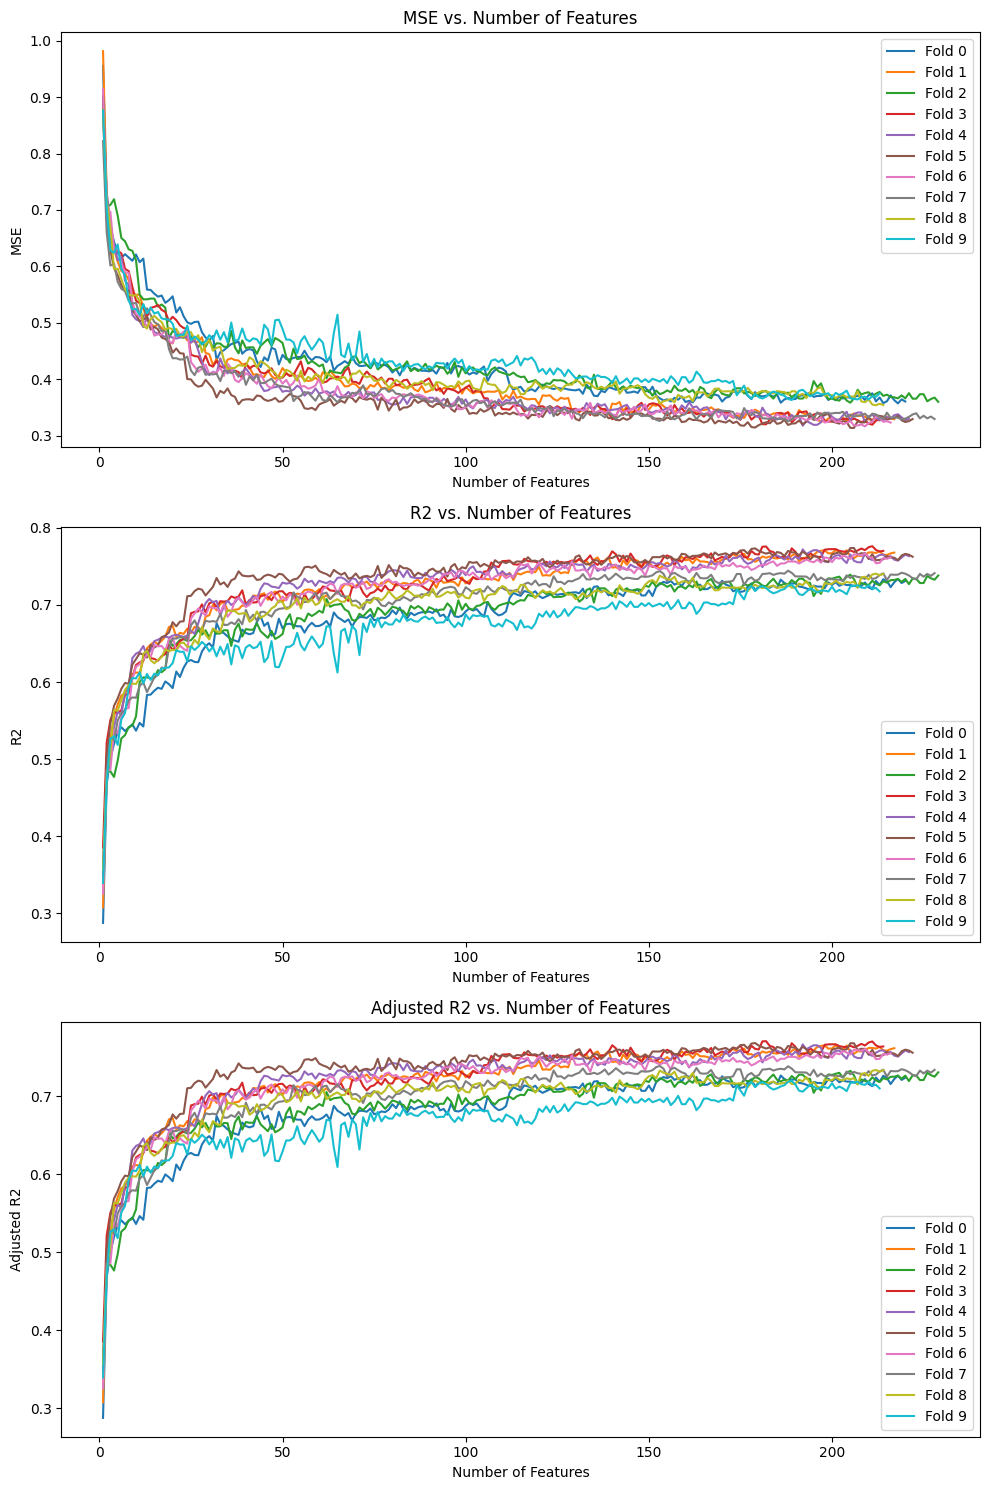

In [16]:
# Preparing data for plotting
data_by_fold = {}
for entry in results:
    fold = entry['Fold']
    if fold not in data_by_fold:
        data_by_fold[fold] = {'Number of Features': [], 'MSE': [], 'R2': [], 'Adjusted R2': []}
    data_by_fold[fold]['Number of Features'].append(entry['Number of Features'])
    data_by_fold[fold]['MSE'].append(entry['MSE'])
    data_by_fold[fold]['R2'].append(entry['R2'])
    data_by_fold[fold]['Adjusted R2'].append(entry['Adjusted R2'])

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plotting MSE
for fold, data in data_by_fold.items():
    axes[0].plot(data['Number of Features'], data['MSE'], label=f'Fold {fold}')
axes[0].set_title('MSE vs. Number of Features')
axes[0].set_xlabel('Number of Features')
axes[0].set_ylabel('MSE')
axes[0].legend()

# Plotting R2
for fold, data in data_by_fold.items():
    axes[1].plot(data['Number of Features'], data['R2'], label=f'Fold {fold}')
axes[1].set_title('R2 vs. Number of Features')
axes[1].set_xlabel('Number of Features')
axes[1].set_ylabel('R2')
axes[1].legend()

# Plotting Adjusted R2
for fold, data in data_by_fold.items():
    axes[2].plot(data['Number of Features'], data['Adjusted R2'], label=f'Fold {fold}')
axes[2].set_title('Adjusted R2 vs. Number of Features')
axes[2].set_xlabel('Number of Features')
axes[2].set_ylabel('Adjusted R2')
axes[2].legend()

plt.tight_layout()
plt.show()